In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from kameleon_mcmc.distribution.Distribution import  Distribution
from kameleon_mcmc.distribution.Gaussian import Gaussian
from kameleon_mcmc.mcmc.MCMCChain import MCMCChain
from kameleon_mcmc.mcmc.MCMCParams import MCMCParams
from kameleon_mcmc.mcmc.output.PlottingOutput import PlottingOutput
from kameleon_mcmc.mcmc.output.StatisticsOutput import StatisticsOutput
from kameleon_mcmc.tools.Visualise import Visualise
from kameleon_mcmc.mcmc.samplers.StandardMetropolis import StandardMetropolis

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
class Target(Distribution):
    def __init__(self, X):
        self.dimension = 2
        
        self.theta1_prior = Gaussian(np.zeros(1), np.eye(1)*10)
        self.theta2_prior = Gaussian(np.zeros(1), np.eye(1))
        
        self.X = X
        
        
    def log_pdf(self, thetas):
        assert(thetas.ndim == 2)
        assert(thetas.shape[1] == self.dimension)
        
        log_pdf = np.zeros(len(thetas))
        for i,theta in enumerate(thetas):
            theta1 = theta[0]
            theta2 = theta[1]
            
            # prior
            log_pdf[i] += self.theta1_prior.log_pdf(np.atleast_2d(theta1))
            log_pdf[i] += self.theta2_prior.log_pdf(np.atleast_2d(theta2))
            
            # likelihood
            component1 = Gaussian(np.zeros(1)+theta1, np.eye(1)*4)
            component2 = Gaussian(np.zeros(1)+theta1+theta2, np.eye(1)*4)
            
            log_lik1 = component1.log_pdf(self.X)
            log_lik2 = component2.log_pdf(self.X)
            
            log_pdf += np.sum(np.log(0.5*np.exp(log_lik1) + 0.5*np.exp(log_lik2)))

            
        return log_pdf
    
    def get_plotting_bounds(self):
        return [(-3, 3), (-3, 3)]
        

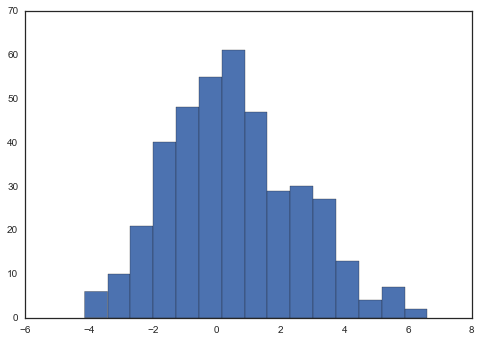

In [18]:
n = 400
X = np.random.randn(n,1)*2
for i in range(n):
    if np.random.rand()<0.5:
        X[i] += 0
    else:
        X[i] += 0+1

        
plt.hist(X, bins=15);

In [7]:
distribution = Target(X)

mcmc_sampler = StandardMetropolis(distribution, scale=8, cov=np.array([[ 0.13065329, -0.24175614],
       [-0.24175614,  0.48168649]]))

start = np.array([1,-1])
mcmc_params = MCMCParams(start=start, num_iterations=500)
chain = MCMCChain(mcmc_sampler, mcmc_params)

chain.append_mcmc_output(StatisticsOutput(lag=100, print_from=100))

chain.run()

iteration: 100
mean acceptance: 0.18
20 percent done in  25 seconds
Since last update: 25 seconds
remaining (estimated): 98 seconds
total (estimated): 123 seconds

iteration: 200
mean acceptance: 0.16
40 percent done in  47 seconds
Since last update: 22 seconds
remaining (estimated): 69 seconds
total (estimated): 116 seconds

iteration: 300
mean acceptance: 0.183333333333
60 percent done in  67 seconds
Since last update: 21 seconds
remaining (estimated): 45 seconds
total (estimated): 112 seconds

iteration: 400
mean acceptance: 0.1775
80 percent done in  86 seconds
Since last update: 19 seconds
remaining (estimated): 21 seconds
total (estimated): 107 seconds



In [ ]:
Xs = np.linspace(-1.5,2,30)
Ys = np.linspace(-3.5,4,30)

D = np.zeros((len(Xs), len(Ys)))

# compute log-density
for i in range(len(Xs)):
    print i
    for j in range(len(Ys)):
        x = np.array([[Xs[i], Ys[j]]])
        D[j, i] = distribution.log_pdf(x)

D-=np.min(D)
D/=np.max(D)
D+=1
D = np.exp(D)



In [ ]:
levels = plt.hist(D)[1][:-1]
levels = np.hstack((levels, np.array([7.2,7.35])))
plt.contour(Xs, Ys, D, origin='lower', levels=levels, linewidths=3, cmap='Reds')
#im.set_extent([Xs.min(), Xs.max(), Ys.min(), Ys.max()])
plt.ylim([Ys.min(), Ys.max()])
plt.xlim([Xs.min(), Xs.max()])

n_plot = 300
start = 200
inds = np.arange(start, start+n_plot)
plt.plot(chain.samples[inds,0], chain.samples[inds,1], 'blue')
plt.savefig("sgld_trace_and_density.pdf")